We import `read_dat` and it handles most things we need. If we need more, we can import them ourselves.

In [1]:
from read_dat import *

file = read_dat(r'../STNG.dat')

init complete


This creates a `read_dat` object, which is the basis for everything that follows. The object is the access to the data file that gets loaded when we call `read_dat` above.

The filename is the only required argument, but there are many options available to us:

```Python
read_dat(file_name, sample_rate, CFD, t_start, t_long, t_short, baseline_samples)
```

| Parameter	| Type	| Details	| Default   |
|---    |---    |---    |---    |
| file_name | str   | Must include file suffix “.dat”   | n/a   |
| sample_rate   | float | ns per sample for the acquired data. | 2 (DT5730 sample rate)  |
| CFD   | array, float  | 1D array of length 3. [Fraction,Length (samples),Offset (samples)]. Refer to `event.CFD` for more information on what these parameters are. | [0.75, 6, 6]  |
| t_start   | array, float  | Start time (ns) from the CFD defined t_0    | [-80] |
| t_long    | array, float  | Long integral gate (ns) from the CFD defined t0   | [400]   |
| t_short   | array, float  | Short integral gate (ns) from the CFD defined t0  | [10]  |
| baseline_samples  | int   | Length of baseline calculation in samples | 200   |



With an object loaded, the most basic thing we can do is read in an event, using `read_event()`. This reads the first event in the file and returns an array containing `event` objects, one for each channel that was set active. In this case, we only have 2 active channels: the anode and the dynode. If the end of the file is reached, `read_event()` returns `True`.

If this method is called again, the next event in the file will be read out. There is currently no way to read an event with a specific event id.

In [29]:
ev = file.read_event()
print(ev)

[<event.event object at 0x7f5a563ea610>, <event.event object at 0x7f5a55e98130>]


The events aren't in a format that we can interpret so we can extract the meaningful information in a few ways.

We can first just get the voltage traces as is, if we want to analyse them ourselves. 

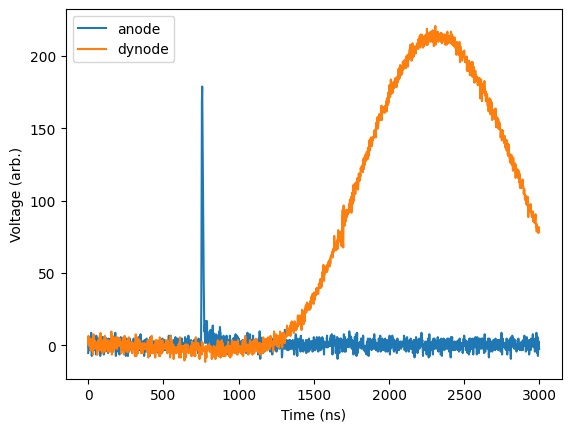

In [23]:
anode_trace = ev[0].get_trace()
dynode_trace = ev[1].get_trace()

time = np.arange(len(anode_trace))*2

plt.plot(time, anode_trace, label='anode')
plt.plot(time, dynode_trace, label='dynode')
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (arb.)')
plt.legend()

We also have access to some basic processing. A long and short integral are calculated

In [2]:
L=[[],[]]
S=[[],[]]
for i in range(1000):#read 1000 events
	event = file.read_event()
	for j in range(len(event)): #per channel
		S[j].append(event[j].get_pulse_shape())
		L[j].append(event[j].get_long_integral())

/home/mkidson/gitRepos/dDAQ_dev/modified_OLD/event.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return self.shortIntegral/self.longIntegral


In [4]:
%matplotlib tk
file.add_selections(L=L[0],S=S[0],mode="m",file="STNG_cuts_SL.csv")

Begin selection for cut 1
1386.0887096774186 0.7148268398268399
9072.580645161288 0.7824675324675325
38684.4758064516 0.8095238095238096
38558.46774193547 0.7472943722943723
756.0483870967746 0.5362554112554113
1008.0645161290322 0.7012987012987013
End selection
Begin selection for cut 2
1260.0806451612898 0.7175324675324676
8820.56451612903 0.7987012987012988
32888.10483870967 0.8257575757575758
32888.10483870967 0.8446969696969697
1386.0887096774186 0.9772727272727274
378.0241935483864 0.9745670995670997
630.0403225806458 0.7175324675324676
End selection
Selections outputted to file: ../STNG_cuts_SL.csv


In [7]:
L_neutrons, S_neutrons = file.select_events(L[0],S[0],cut_id = [0],inc=[-1], visual=True)


0


In [8]:
L_gammas, S_gammas = file.select_events(L[0],S[0],cut_id = [1],inc=[1], visual=True)

1


In [9]:
cmap_r = cm.get_cmap("Blues_r")


In [10]:
plt.figure()     
h, xedges, yedges,images= plt.hist2d(L[0],S[0],[256,256],[[0,40000],[0,1]],norm=colors.LogNorm(vmin=1),cmap=cmap_r)
plt.xlabel("L[ch]")
plt.ylabel("S[ch]")
plt.show()
#or without visual:
# h, xedges, yedges = np.histogram2d(L,S,[256,256],[[0,40000],[0,1]])
header = "AmBe.dat SL [256,256] [[0,40000],[0,1]]"
np.savetxt("SL_AmBe_2dhist.txt",h,header=header)


In [8]:
plt.figure()
n, bins, patches = plt.hist(L_neutrons,256,(0,40000))
plt.xlabel("L[ch]")
plt.ylabel("Counts")
plt.show()
#for without visual:
n_g, bins_g = np.histogram(L_gammas,256,(0,40000))

header = "AmBe.dat L neutrons cut 0, bins 256, [0,40000]\n L[ch]\tCounts"
np.savetxt("SL_AmBe_1dL_neutrons.txt",np.array([bins[:-1],n]).T,header=header)

header = "AmBe.dat L gammas cut 0, bins 256, [0,40000]\n L[ch]\tCounts"
np.savetxt("SL_AmBe_1dL_gammas.txt",np.array([bins_g[:-1],n_g]).T,header=header)


In [9]:
file.get_fails(display=True)


Channel: 0	Events: 1000	Fails: 1.0
tstart: 0.0	tlong: 1.0	tshort: 0.0	integral: 0.0	t0: 0.0
Channel: 1	Events: 1000	Fails: 7.0
tstart: 7.0	tlong: 0.0	tshort: 0.0	integral: 0.0	t0: 0.0


(array([[0., 1., 0., 0., 0.],
        [7., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([1., 7., 0., 0., 0., 0., 0., 0.]),
 1000)